------------
INSTRUCTIONS
-------------

Run each cell from top to bottom. The final cell allows you to save the generated data after all other cells were executed. Running the final cell is not mandatory, do it only if you wish to save the data. The data will be saved to the folder where this code is stored.

If this is your first time running the code, type ctrl + F and then type r'C, this will take you to the parts of the code where an instruction to read a specific path in your computer is given. Make sure that the path exists in your computer and that it corresponds to the path where the file being specified can be found.

------------
DESCRIPTIONS
-------------

Normal modes file: File containing the normal modes of the biomolecule whose theoretical B-factor you wish to calculate.

Eigenvalues file: File containing the eigenvalues of the biomolecule whose theoretical B-factor you wish to calculate.

Mass vector file: File containing the masses of the biomolecule whose theoretical B-factor you wish to calculate.

Temperature for atomic fluctuations (K): It makes sense to match this value to the crystalization experiment temperature. The crystalization experiment temperature can sometimes be found in the Protein Data Bank entry of the biomolecule you are analyzing. For example, if you were analyzing the STMV capsid from PDB entry 4OQ8, you can go to https://www.rcsb.org/pdb/explore/materialsAndMethods.do?structureId=4OQ8 to check the crystalization experiment temperature. Suggested value: 300.

Number of modes to consider for B-factors calculation: Type "all" if you want to consider all the available normal modes to calculate the theoretical B-factors. Suggested value: all.

Normalize B-factors?: You can choose to normalize the B-factors if you are only interested in the shape of the curve. Suggested value: no.

In [1]:
# LIBRARIES AND FUNCTIONS

# Libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy import integrate    
from pathlib import Path
import pandas as pd
import numpy as np
import os

# Integer validation
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
    return False

In [2]:
# FILES

# Normal modes file directory
NormalModesFile = 0
while NormalModesFile == 0:
    NormalModesFile = input('\033[1m' + 'Normal modes file: ' + '\033[0')
    if 'normalModes' not in NormalModesFile:
        NormalModesFile = 0
        print('This is not a normal modes file')
    elif 'normalModes' in NormalModesFile:
        NormalModesFile = NormalModesFile + '.csv'
        NormalModesPath  = os.path.join(r'C:\Users\santi\Desktop\2019\Biophysics\Data', NormalModesFile)
        if Path(NormalModesPath).is_file() == False:
            NormalModesFile = 0
            print('File not found')
dfNM = pd.read_csv(NormalModesPath)
dfNM.index = np.arange(1, len(dfNM) + 1)
N = int(dfNM.shape[0]/3) # Number of nodes from normal modes file
dfNM.index = ['x' + str(i) for i in range(1, N + 1)] + ['y' + str(i) for i in range(1, N + 1)] + ['z' + str(i) for i in range(1, N + 1)]
dfNM.index.name = 'Coordinate'
del dfNM['Coordinate']
HowMany = dfNM.shape[1] # Number of modes from normal modes file
Eigenvectors = np.zeros((3*N, HowMany))
Eigenvectors = dfNM.values # Eigenmatrix from normal modes file

# Eigenvalues file directory
EigenvaluesFile = 0
while EigenvaluesFile == 0:
    EigenvaluesFile = input('\033[1m' + 'Eigenvalues file: ' + '\033[0')
    if 'eigenvalues' in EigenvaluesFile:
        if 'Results' in EigenvaluesFile:
            EigenvaluesFile = 0
            print('This is not an eigenvalues file')
        else:
            EigenvaluesFile = EigenvaluesFile + '.csv'
            EigenvaluesPath  = os.path.join(r'C:\Users\santi\Desktop\2019\Biophysics\Data', EigenvaluesFile)
            if Path(EigenvaluesPath).is_file() == False:
                EigenvaluesFile = 0
                print('File not found')
dfEV = pd.read_csv(EigenvaluesPath)
dfEV.index = np.arange(1, len(dfEV) + 1)
dfEV.index.name = 'Node'
Eigenvalues = dfEV.values # Eigenvalues from eigenvalues file
AngularFrequencies = Eigenvalues[:,1]

# Mass vector file directory
MassFile = 0
while MassFile == 0:
    MassFile = input('\033[1m' + 'Mass vector file: ' + '\033[0')
    if 'mass' not in MassFile:
        MassFile = 0
        print('This is not a mass vector file')
    elif 'mass' in MassFile:
        MassFile = MassFile + '.csv'
        MassPath  = os.path.join(r'C:\Users\santi\Desktop\2019\Biophysics\Data', MassFile)
        if Path(MassPath).is_file() == False:
            MassFile = 0
            print('File not found')
dfMass = pd.read_csv(MassPath)
dfMass.index = np.arange(1, len(dfMass) + 1)
dfMass.index.name = 'Node'
MassVector = np.zeros((N))
MassVector = dfMass.values # Masses from masses file
MassVector = np.transpose(MassVector)[1]

print('Done')

Normal modes file: 5WB0_CG_100normalModes_cutoff20.0angstroms_kvariable_variableMass108.3573Da
Eigenvalues file: 5WB0_CG_100eigenvalues_cutoff20.0angstroms_kvariable_variableMass108.3573Da
Mass vector file: 5WB0_CG_variableMass_massVector
Done


Temperature for atomic fluctuations (K): 300
Number of modes to consider for B-factors calculation: all
Normalize B-factors? yes


<IPython.core.display.Javascript object>


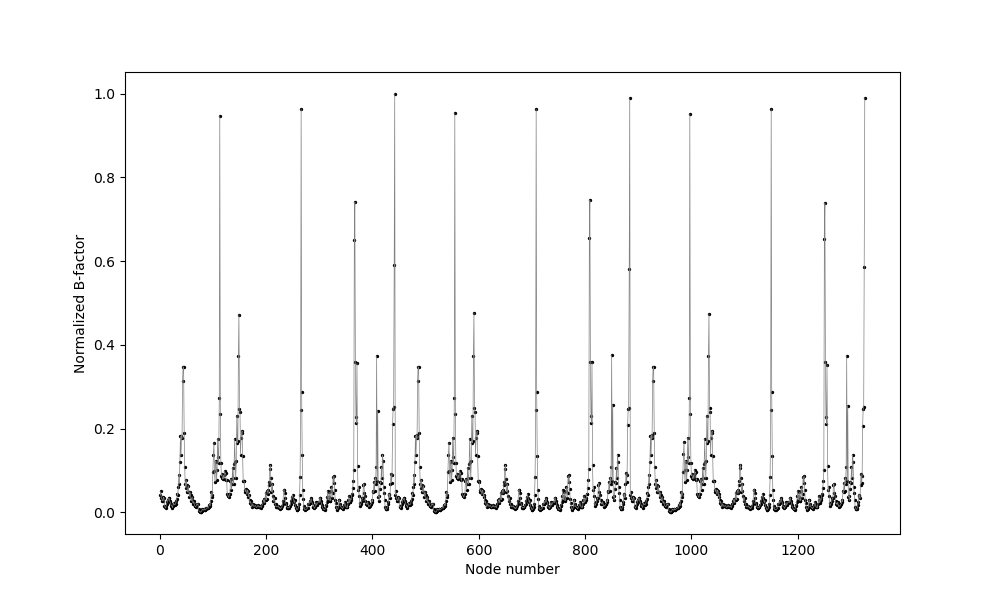

In [6]:
# THEORETICAL B-FACTORS

# Enable dynamic graphs mode
%matplotlib nbagg

# Experiment temperature
T = 0
while T == 0:
    T = input('\033[1m' + 'Temperature for atomic fluctuations (K): ' + '\033[0')
    if is_number(T) == True:
        if float(T) < 0:
            T = 0
            print('Must be positive')
        elif float(T) == 0:
            print('Temperature cannot be zero')
        else:
            T = float(T)
    else:
        T = 0
        print('Must be a number')

# Number of modes to include in atomic fluctuations
HowManyModes = 0
while HowManyModes == 0:
    HowManyModes = input('\033[1m' + 'Number of modes to consider for B-factors calculation: ' + '\033[0')
    if str(HowManyModes) == 'all':
        HowManyModes = HowMany
    elif is_number(HowManyModes) == True:
        if float(HowManyModes) <= 0:
            HowManyModes = 0
            print('Must be positive')
        else:
            if (float(HowManyModes)).is_integer() == False:
                HowManyModes = 0
                print('Must be an integer')
            elif int(HowManyModes) > HowMany:
                HowManyModes = 0
                print('There are only ' + str(HowMany) + ' available modes')
            elif int(HowMany) < 2:
                HowManyModes = 0
                print('Must consider at least two modes')
            else:
                HowManyModes = int(HowManyModes)
    else:
        HowManyModes = 0
        print('Must be a number or <all>')

# Normalize B-factors?
Normalize = 0
while Normalize == 0:
    Normalize = input('\033[1m' + 'Normalize B-factors? ' + '\033[0')
    if Normalize not in {'yes', 'no'}:
        Normalize = 0
        print('Answer must be yes or no')
    elif Normalize in {'yes', 'no'}:
        Normalize = str(Normalize)
        
# Parameters
c = (1.38065*10**(-23))*T # Boltzmann constant (J/K) times the temperature (K)
MassVectorkg = np.zeros((N))
BFactors = np.zeros((N))
# Mass vector from Da to kg
for i in range(0,N):
    MassVectorkg[i] = 1.660539*10**(-27)*MassVector[i]
# B-factors (angstrom^2) 
for i in range(0, N):
    BFactorsSum = 0
    for j in range(7, HowManyModes):
        BFactorsSum = BFactorsSum + ((Eigenvectors[i,j])**2+(Eigenvectors[N+i,j])**2+(Eigenvectors[2*N+i,j])**2)/(AngularFrequencies[j])**2
    BFactors[i] = (c/MassVectorkg[i])*BFactorsSum # Theoretical B-factors in meters
    BFactors[i] = 10**20*(((8*np.pi**2)/3)*BFactors[i]) # Theoretical B-factors in angstroms
# Check if B-factors must be normalized
BFactorsMin = np.amin(BFactors)
BFactorsMax = np.amax(BFactors)
if Normalize == 'yes':
    for i in range(0,N):
        BFactors[i] = (BFactors[i] - BFactorsMin)/(BFactorsMax - BFactorsMin)    
# Graphs
fig1_size = plt.rcParams["figure.figsize"]
fig1_size[0] = 10
fig1_size[1] = 6
fig1, ax1 = plt.subplots()
if Normalize == 'no':
    ax1.set(xlabel = 'Node number', ylabel = 'B-factor (angstroms^2)')
    BFactorsRange = BFactorsMax - BFactorsMin
    ax1.set_ylim(BFactorsMin - 0.05*BFactorsRange, BFactorsMax + 0.05*BFactorsRange)
elif Normalize == 'yes':
    ax1.set(xlabel = 'Node number', ylabel = 'Normalized B-factor')
i = np.arange(1, N + 1, 1)
ax1.scatter(i, BFactors, c = 'black', s = 2)
ax1.plot(i, BFactors, c = 'gray', linewidth = 0.5, linestyle = '-')

plt.show()

# Dataframes
if Normalize == 'no':
    df1 = pd.DataFrame({'B-factors (angstroms^2)': BFactors})
elif Normalize == 'yes':
    df1 = pd.DataFrame({'Normalized B-factors': BFactors})
df1.index = np.arange(1, len(df1) + 1)
df1.index.name = 'Node'

In [ ]:
# SAVE FILES

if 'df1' in locals():
    if Normalize == 'no':
        df1.to_csv('BFactors_' + str(T) + 'K_' + str(HowManyModes) + 'modes.csv')
    elif Normalize == 'yes':
        df1.to_csv('normalizedBFactors_' + str(T) + 'K_' + str(HowManyModes) + 'modes.csv')
elif 'df1' not in locals():
    print('No data available')